In [55]:
import numpy as np
import math
import time
import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import TwoSlopeNorm
from scipy import sparse
import seaborn as sns
from sympy.combinatorics import Permutation, PermutationGroup

import netket as nk
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import json

PATH = os.getcwd()

### Generate Table of All Possible States Indexed in Lexigraphical Order

In [56]:
def generateStateTable(n,n0,N): # assumes ab > n0 > 0 and N = n choose n0
    states = []
    state = [1]*(n-n0) + [-1]*n0
    for i in range(0,N):
        states.append(state)
        j = 0
        flag = True
        flip_count = 0
        up_count = 0
        while (flag): 
            if (j == n-1):
                for m in range(0,n):
                    if (state[m] != 1 and state[m+1] == 1):
                        flip_count += 1
                if (flip_count == 1):
                    break
            if (state[j] != 1):
                j += 1  
            elif (state[j+1] != 1):
                for m in range(0,j):
                    if (state[m] != 1 and state[m+1] == 1):
                        flip_count += 1
                    if (state[m] == 1):
                        up_count += 1
                if (flip_count == 1):
                    state[j],state[j+1] = state[j+1],state[j]
                    for k in range(1,up_count+1):
                        state[j-k],state[k-1] = state[k-1],state[j-k]
                else:
                    state[j],state[j+1] = state[j+1],state[j]
                flag = False
            else:
                j += 1
    return states

### Generate Adjacency Matrices

In [57]:
class Node:
    def __init__(self, position, xadj, yadj):
        self.position = position
        self.xadj = xadj
        self.yadj = yadj
    
    def __str__(self):
        return f"{self.position} {self.xadj} {self.yadj}"

In [58]:
def squareAdjacencyList(a,b): # constructs a periodic adjacency graph with width a and height b
    nodes = []
    for j in range(0,b):
        for i in range(0,a):
            xadj = [[(i-1) % a,j],[(i+1) % a,j]]
            yadj = [[i,(j-1) % b],[i,(j+1) % b]]
            nodes.append(Node([[i,j]],xadj,yadj))

    return nodes

### First Neighbors Adjacency Matrix

In [59]:
def firstneighbors(a,b): 
    nodes = squareAdjacencyList(a,b)
    N = a*b
    J = [[0 for col in range(N)] for row in range(N)]

    for i in range(0,N-1):
        for j in range(i+1,N):
            flag = False
            for xptr in nodes[i].xadj:
                if xptr in nodes[j].position:
                    flag = True
            for yptr in nodes[i].yadj:
                if yptr in nodes[j].position:
                    flag = True
            if flag:
                J[i][j] = 1
                J[j][i] = 1
        
    return np.array(J)

### Second Neighbors (Euclidean) Adjacency Matrix

In [60]:
def secondneighbors(a,b):
    nodes = squareAdjacencyList(a,b)
    N = a*b
    J = [[0 for col in range(N)] for row in range(N)]

    for i in range(0,N-1):
        for j in range(i+1,N):
            flag = False

            for xptr in nodes[i].xadj:
                try:
                    for k in range(0,N):
                        if xptr in nodes[k].position:
                            intermediate = k
                    for yptr in nodes[intermediate].yadj:
                        if yptr in nodes[j].position:
                            flag = True
                except UnboundLocalError:
                    pass

            if flag:
                J[i][j] = 1
                J[j][i] = 1

    return np.array(J)

### Model Parameters

In [61]:
a = 4 # x-range of supercell
b = 4 # y-range of supercell
N1 = firstneighbors(a,b)
N2 = secondneighbors(a,b)
n = a*b # number of sites in lattice

n0 = n // 2 # number of down spins in the string (taken as floor(n/2))
N = int(math.factorial(n)/(math.factorial(n0)*math.factorial(n-n0))) # number of states

stateTable = generateStateTable(n,n0,N)

### Reduce Fock Space

In [62]:
def stateValBin(state):
    sum = 0
    for i in range(len(state)):
        if state[i] == 1:
            sum += 2**i
    return sum

def searchState(state):
    high = N-1
    low = 0
    while True:
        mid = math.floor((high+low)/2)
        if np.array_equal(state,stateTable[mid]):
            return mid
        elif stateValBin(state) > stateValBin(stateTable[mid]):
            low = mid+1
        else:
            high = mid-1

In [63]:
def transSym(state,x,y): # translation vector (x,y)
    newState = []
    for j in range(b):
        for i in range(a):
            ii = (i-x) % a
            jj = (j-y) % b 
            newState.append(state[a*jj+ii])
    return newState

def spinFlipSym(state):
    return -1*state

def rotSiteSym(state,n): # rotate about the origin by n\pi/2 radians CCW
    newState = []
    if n % 4 == 0:
        return state
    elif n % 4 == 1:
        for j in range(b):
            for i in range(a):
                ii = j % a
                jj = (-i) % b
                newState.append(state[a*jj+ii])
    elif n % 4 == 2:
        for j in range(b):
            for i in range(a):
                ii = (-i) % a
                jj = (-j) % b
                newState.append(state[a*jj+ii])
    else:
        for j in range(b):
            for i in range(a):
                ii = (-j) % a
                jj = i % b
                newState.append(state[a*jj+ii])

    return newState

def rotCentSym(state,n): # rotate about the center of the primitive cell [0-1]x[0-1] by n\pi/2 radians CCW 
    newState = []
    if n % 4 == 0:
        return state
    elif n % 4 == 1:
        for j in range(b):
            for i in range(a):
                ii = (j-0.5) % a 
                jj = (-i+0.5) % b
                ii = (ii+0.5) % a
                jj = (jj+0.5) % b
                newState.append(state[int(a*jj+ii)])
    elif n % 4 == 2:
        for j in range(b):
            for i in range(a):
                ii = (-i+0.5) % a
                jj = (-j+0.5) % b
                ii = (ii+0.5) % a
                jj = (jj+0.5) % b
                newState.append(state[int(a*jj+ii)])
    else:
        for j in range(b):
            for i in range(a):
                ii = (-j+0.5) % a 
                jj = (i-0.5) % b
                ii = (ii+0.5) % a
                jj = (jj+0.5) % b
                newState.append(state[int(a*jj+ii)])
    return newState

def rotHorEdgeSym(state): # rotate about the center of the edge connecting (0,0) with (1,0) by \pi radians

    newState = []
    for j in range(b):
        for i in range(a):
            ii = (-i+0.5) % a
            jj = (-j) % b
            ii = (ii+0.5) % a
            newState.append(state[int(a*jj+ii)])
    return newState

def rotVertEdgeSym(state): # rotate about the center of the edge connecting (0,0) with (0,1) by \pi radians
    newState = []
    for j in range(b):
        for i in range(a):
            jj = (-j+0.5) % b
            ii = (-i) % a
            jj = (jj+0.5) % b
            newState.append(state[int(a*jj+ii)])
    return newState

def refVertSym(state): # reflect about the line x = 0
    newState = []
    for j in range(b):
        for i in range(a):
            ii = (-i) % a
            jj = j
            newState.append(state[int(a*jj+ii)])
    return newState

def refHorSym(state): # reflect about the line y = 0
    newState = []
    for j in range(b):
        for i in range(a):
            ii = i
            jj = (-j) % b
            newState.append(state[int(a*jj+ii)])
    return newState

def refVertCentSym(state): # reflect about the line x = 0.5
    newState = []
    for j in range(b):
        for i in range(a):
            ii = (-i+0.5) % a
            jj = j
            ii = (ii+0.5) % a
            newState.append(state[int(a*jj+ii)])
    return newState

def refHorCentSym(state): # reflect about the line y = 0.5
    newState = []
    for j in range(b):
        for i in range(a):
            ii = i
            jj = (-j+0.5) % b
            jj = (jj+0.5) % b
            newState.append(state[int(a*jj+ii)])
    return newState

def refDiagSym(state): # reflect about the line y = x
    newState = []
    for j in range(b):
        for i in range(a):
            ii = j
            jj = i
            newState.append(state[int(a*jj+ii)])
    return newState

def refOffDiagSym(state): # reflect about the line y = -x
    newState = []
    for j in range(b):
        for i in range(a):
            ii = (-j) % a
            jj = (-i) % b
            newState.append(state[int(a*jj+ii)])
    return newState

### Generate Symmetry Group

In [64]:
identity = range(n)
isSquare = (a == b)

gen = []

gen.append(transSym(identity,1,0))
gen.append(transSym(identity,0,1))

if isSquare:
    gen.append(rotSiteSym(identity,1))
    gen.append(rotCentSym(identity,1))
    gen.append(rotHorEdgeSym(identity))
    
    gen.append(refVertSym(identity))
    gen.append(refVertCentSym(identity))
    gen.append(refDiagSym(identity))
else:
    gen.append(rotSiteSym(identity,2))
    gen.append(rotCentSym(identity,2))
    gen.append(rotHorEdgeSym(identity))
    gen.append(rotVertEdgeSym(identity))

    gen.append(refVertSym(identity))
    gen.append(refVertCentSym(identity))
    gen.append(refHorSym(identity))
    gen.append(refHorCentSym(identity))

print(gen)

[[3, 0, 1, 2, 7, 4, 5, 6, 11, 8, 9, 10, 15, 12, 13, 14], [12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [0, 12, 8, 4, 1, 13, 9, 5, 2, 14, 10, 6, 3, 15, 11, 7], [4, 0, 12, 8, 5, 1, 13, 9, 6, 2, 14, 10, 7, 3, 15, 11], [1, 0, 3, 2, 13, 12, 15, 14, 9, 8, 11, 10, 5, 4, 7, 6], [0, 3, 2, 1, 4, 7, 6, 5, 8, 11, 10, 9, 12, 15, 14, 13], [1, 0, 3, 2, 5, 4, 7, 6, 9, 8, 11, 10, 13, 12, 15, 14], [0, 4, 8, 12, 1, 5, 9, 13, 2, 6, 10, 14, 3, 7, 11, 15]]


In [65]:
G = PermutationGroup(np.array(gen))
G.order()

128

In [66]:
strGens = [[gen[i][j]+1 for j in range(len(gen[0]))] for i in range(len(gen))]
strGens = str(strGens)
strGens = strGens.replace('[', '(').replace(']', ')')
print(strGens)

((4, 1, 2, 3, 8, 5, 6, 7, 12, 9, 10, 11, 16, 13, 14, 15), (13, 14, 15, 16, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), (1, 13, 9, 5, 2, 14, 10, 6, 3, 15, 11, 7, 4, 16, 12, 8), (5, 1, 13, 9, 6, 2, 14, 10, 7, 3, 15, 11, 8, 4, 16, 12), (2, 1, 4, 3, 14, 13, 16, 15, 10, 9, 12, 11, 6, 5, 8, 7), (1, 4, 3, 2, 5, 8, 7, 6, 9, 12, 11, 10, 13, 16, 15, 14), (2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15), (1, 5, 9, 13, 2, 6, 10, 14, 3, 7, 11, 15, 4, 8, 12, 16))


In [72]:
strStates = str(stateTable)
strStates = strStates.replace('[', '(').replace(']', ')')
strStates = strStates.replace('((', '[(').replace('))', ')]')
print(strStates)

[(-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1), (-1, -1, -1, 

### Generate All Orbits

In [67]:
orbits = []
signs = []

def isVisited(index):
    for orbit in orbits:
        if (index,-1) in orbit or (index,1) in orbit:
            return True
    return False

flip = (a*b) % 4 == 0

ptr = 0

while ptr < N:
    orbit = []
    orbit.append((ptr,1))
    for g in G.generate():
        newState = np.array([stateTable[ptr][g(i)] for i in range(n)])
        if flip: orbit.append((searchState(newState),1))
        else: orbit.append((searchState(newState),g.signature()))
        if n % 2 == 0: 
            if flip: orbit.append((searchState(spinFlipSym(newState)),1))
            else: orbit.append((searchState(spinFlipSym(newState)),-1*g.signature()))
    orbit = list(set(orbit))
    orbits.append(orbit)
    while isVisited(ptr):
        ptr += 1

KeyboardInterrupt: 

107


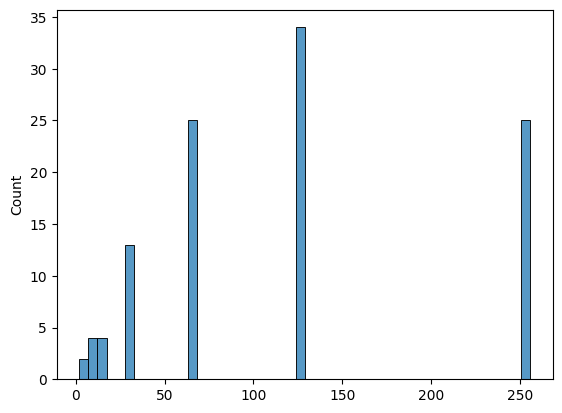

In [ ]:
orbitLengths = [len(orbits[i]) for i in range(len(orbits))]

sns.histplot(orbitLengths,bins=50)
NN = len(orbits)
print(NN)

### Compute Reduced Hamiltonian

In [ ]:
def computeHamEntry(J1,J2,i,j):
    sum = 0.0
    if (i == j):
        for k in range(0,n-1):
            for l in range(k+1,n):
                if (N1[k][l] != 0):
                    sum += J1*stateTable[i][k]*stateTable[i][l]
                if (N2[k][l] != 0):
                    sum += J2*stateTable[i][k]*stateTable[i][l]          
    else:
        tempState = np.multiply(stateTable[i],stateTable[j])
        if (np.count_nonzero(tempState == -1) == 2):
            indices = np.where(tempState == -1)
            e,f = indices[0][0],indices[0][1]
            if (N1[e][f] != 0):
                sum += 2*J1
            if (N2[e][f] != 0):
                sum += 2*J2
    
    return sum

def computeRedHam(J1,J2):
    row = []
    col = []
    data = []

    for i in range(0,NN):
        for j in range(i,NN):
            if (i == j):
                row.append(i)
                col.append(j)
                data.append(computeHamEntry(J1,J2,orbits[i][0][0],orbits[j][0][0]))
            else:
                sum = 0
                if len(orbits[i]) <= len(orbits[j]):
                    for k in orbits[i]:
                        sum += computeHamEntry(J1,J2,k[0],orbits[j][0][0])*k[1]*orbits[j][0][1]
                    sum *= len(orbits[j])
                else:
                    for k in orbits[j]:
                        sum += computeHamEntry(J1,J2,orbits[i][0][0],k[0])*orbits[i][0][1]*k[1]
                    sum *= len(orbits[i])
                sum /= np.sqrt(len(orbits[i])*len(orbits[j]))

                row.append(i)
                row.append(j)
                col.append(j)
                col.append(i)
                data.append(sum)
                data.append(sum)
    
    H = sparse.coo_array((data, (row, col)), shape=(NN,NN), dtype=np.float32)
    return H

In [ ]:
H = computeRedHam(1,0)
print(orbits)
print(H.toarray())
energies, states = sparse.linalg.eigs(H.asfptype(), k=1, which='SR')
energies = np.real(energies)
states = np.real(states)

energies,states

[[(0, 1), (5082, 1), (12869, 1), (12375, 1), (10641, 1), (7787, 1), (2228, 1), (494, 1)], [(824, 1), (45, 1), (5895, 1), (10649, 1), (5699, 1), (12383, 1), (10847, 1), (10598, 1), (456, 1), (11364, 1), (9579, 1), (1766, 1), (1354, 1), (458, 1), (1292, 1), (9537, 1), (6429, 1), (11577, 1), (2747, 1), (3581, 1), (10747, 1), (1160, 1), (1294, 1), (6442, 1), (1505, 1), (12413, 1), (10122, 1), (7014, 1), (486, 1), (9860, 1), (3332, 1), (12045, 1), (5121, 1), (7806, 1), (2022, 1), (499, 1), (488, 1), (12868, 1), (12857, 1), (11043, 1), (7722, 1), (5070, 1), (877, 1), (12381, 1), (12392, 1), (5708, 1), (3, 1), (3009, 1), (12370, 1), (5855, 1), (6427, 1), (6053, 1), (11575, 1), (3007, 1), (3218, 1), (4851, 1), (2122, 1), (9288, 1), (6440, 1), (8018, 1), (12411, 1), (12105, 1), (11709, 1), (7923, 1), (561, 1), (1133, 1), (3290, 1), (2271, 1), (9210, 1), (2220, 1), (6974, 1), (12866, 1), (501, 1), (7161, 1), (11103, 1), (11992, 1), (10, 1), (5147, 1), (6947, 1), (7781, 1), (12390, 1), (47, 1), (

(array([-44.913975], dtype=float32),
 array([[-0.00212579],
        [-0.01521355],
        [ 0.0069814 ],
        [ 0.02289094],
        [ 0.00987319],
        [-0.00554923],
        [-0.01075761],
        [-0.01104779],
        [ 0.06376523],
        [-0.02369666],
        [-0.0083302 ],
        [ 0.01861548],
        [-0.03176799],
        [ 0.02432853],
        [-0.038341  ],
        [-0.04306673],
        [ 0.03497644],
        [-0.03351218],
        [ 0.06376524],
        [-0.00298518],
        [ 0.01316321],
        [-0.00589023],
        [-0.007812  ],
        [-0.02165284],
        [ 0.01720274],
        [-0.04331871],
        [ 0.02761461],
        [-0.06987438],
        [-0.053997  ],
        [ 0.02473201],
        [ 0.05895694],
        [-0.00513589],
        [-0.00908351],
        [-0.04778859],
        [ 0.02517604],
        [-0.02246341],
        [ 0.06669419],
        [-0.05018089],
        [-0.01774529],
        [ 0.0926402 ],
        [-0.03310475],
        [ 0.06587388

In [ ]:
for i in range(min(NN,10)):
    for j in range(min(NN,10)):
        if i == j:
            break
        else:
            lsts = []
            for k in range(len(orbits[j])):
                lst = []
                sum = 0
                for l in range(len(orbits[i])):
                    sum += computeHamEntry(1,0,orbits[j][k][0],orbits[i][l][0])*orbits[j][k][1]*orbits[i][l][1]
                lsts.append(sum)
            print(lsts)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.

### Convert Back to Full Basis

In [ ]:
def toFullBasis(reducedBasisState):
    ret = np.zeros(N)
    for i in range(len(orbits)):
        for j in range(len(orbits[i])):
            ret[orbits[i][j][0]] = reducedBasisState[i]*orbits[i][j][1]/np.sqrt(len(orbits[i]))

    return ret

fullState = toFullBasis(states.T[0])

In [ ]:
H = sparse.load_npz(PATH + '/data/'+str(a)+'x'+str(b)+'hamiltonian.npz')

grdEnergy, grdState = sparse.linalg.eigs(H.asfptype(), k=1, which='SR')
grdEnergy = np.real(grdEnergy)
grdState = np.real(grdState).T[0]

In [ ]:
lattice = nk.graph.Grid(extent=[b,a], pbc=True)
hilbertSpace = nk.hilbert.Spin(s=0.5, total_sz=0.5*(n-2*n0), N=a*b)
hamiltonian = nk.operator.Heisenberg(hilbert=hilbertSpace, graph=lattice)

netketH = hamiltonian.to_sparse().toarray()

evals = nk.exact.lanczos_ed(hamiltonian,compute_eigenvectors=True)
netState = evals[1].T[0]

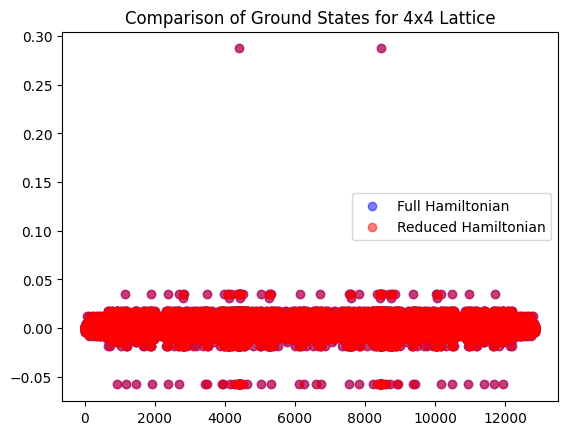

In [ ]:
fullState /= np.linalg.norm(fullState)
grdState /= np.linalg.norm(grdState)
if np.sum((grdState-fullState)**2) > np.sum((grdState+fullState)**2): fullState *= -1
if np.sum((grdState-netState)**2) > np.sum((grdState+netState)**2): netState *= -1

plt.scatter(range(N),grdState, color="blue", label="Full Hamiltonian", alpha=0.5)
plt.scatter(range(N),fullState, color="red", label="Reduced Hamiltonian", alpha=0.5)
# plt.scatter(range(N),netState, color="green", label="NetKet Hamiltonian", alpha=0.5)
plt.title("Comparison of Ground States for "+str(a)+"x"+str(b)+" Lattice")
plt.legend()
plt.show()

In [ ]:
np.sum((grdState-fullState)**2)

1.514676475033814e-11